<a href="https://colab.research.google.com/github/nlahri/dsba6211-summer2024/blob/main/notebooks/dsba6211_summer2024_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [4]:
%%capture
!pip install skorecard@git+https://github.com/wesslen/skorecard # for a fix in the scorecard_scorer
#!pip install --upgrade scikit-learn
!pip install scikit-learn==1.5.0


This uses the [South German Credit Dataset](https://archive.ics.uci.edu/dataset/573/south+german+credit+update), which fixed several issues with an older German Credit Dataset.

In [5]:
import pandas as pd

data_url = "https://github.com/shrutibalan4591/South-German-Credit-Risk-Classification/raw/main/Data/German_credit.csv"

df = pd.read_csv(data_url)

df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [6]:
# 0 = Good, 1 = Bad
y = df.credit_risk

df['credit_risk'].value_counts()

credit_risk
1    700
0    300
Name: count, dtype: int64

In [7]:
X = df.drop(columns=['credit_risk'])

# print datatype
X.dtypes

status                     int64
duration                   int64
credit_history             int64
purpose                    int64
amount                     int64
savings                    int64
employment_duration        int64
installment_rate           int64
personal_status_sex        int64
other_debtors              int64
present_residence          int64
property                   int64
age                        int64
other_installment_plans    int64
housing                    int64
number_credits             int64
job                        int64
people_liable              int64
telephone                  int64
foreign_worker             int64
dtype: object

## Variable descriptions

For now, let's limit our variables to these variables.

### Status
| Code | Description |
|------|-------------|
| 1    | No checking account |
| 2    | ... < 0 DM |
| 3    | 0 <= ... < 200 DM |
| 4    | ... >= 200 DM / salary for at least 1 year |

### Credit History
| Code | Description |
|------|-------------|
| 0    | Delay in paying off in the past |
| 1    | Critical account/other credits elsewhere |
| 2    | No credits taken/all credits paid back duly |
| 3    | Existing credits paid back duly till now |
| 4    | All credits at this bank paid back |

### Purpose
| Code | Description |
|------|-------------|
| 0    | Others |
| 1    | Car (new) |
| 2    | Car (used) |
| 3    | Furniture/equipment |
| 4    | Radio/television |
| 5    | Domestic appliances |
| 6    | Repairs |
| 7    | Education |
| 8    | Vacation |
| 9    | Retraining |
| 10   | Business |

### Installment Rate
| Code | Description |
|------|-------------|
| 1    | >= 35 |
| 2    | 25 <= ... < 35 |
| 3    | 20 <= ... < 25 |
| 4    | < 20 |

### Duration
Credit duration in months


In [8]:
X = X[['status', 'credit_history', 'purpose', 'installment_rate', 'duration']]

In [9]:
X['credit_history'].value_counts()

credit_history
2    530
4    293
3     88
1     49
0     40
Name: count, dtype: int64

## Pre-processing

### Partition

In [10]:
# test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Bucketing: Categorical

[Weight of Evidence and Information Value Explained](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

In [11]:
from skorecard import datasets
from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, AsIsCategoricalBucketer, EqualWidthBucketer
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline

num_cols = ["duration"]
cat_cols = ['status', 'credit_history', 'purpose', 'installment_rate']

bucketing_process = BucketingProcess(
    # specials={'duration': {'=400000.0' : [400000.0]}},
    prebucketing_pipeline=make_pipeline(
        EqualWidthBucketer(n_bins=100, variables=num_cols),
        AsIsCategoricalBucketer(variables=cat_cols),
    ),
    bucketing_pipeline=make_pipeline(
        DecisionTreeBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05),
        OptimalBucketer(variables=cat_cols, variables_type='categorical', max_n_bins=10, min_bin_size=0.05),
    )
)

bucketing_process.fit(X, y)

(CVXPY) Jun 15 07:58:04 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 15 07:58:04 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


BucketingProcess(bucketing_pipeline=Pipeline(steps=[('decisiontreebucketer',
                                                     DecisionTreeBucketer(max_n_bins=10,
                                                                          variables=['duration'])),
                                                    ('optimalbucketer',
                                                     OptimalBucketer(variables=['status',
                                                                                'credit_history',
                                                                                'purpose',
                                                                                'installment_rate'],
                                                                     variables_type='categorical'))]),
                 prebucketing_pipeline=Pipeline(steps=[('equalwidthbucketer',
                                                        EqualWidthBucketer(n_bins=100,
                                                                           variables=['duration'])),
                                                       ('asiscategoricalbucketer',
                                                        AsIsCategoricalBucketer(variables=['status',
                                                                                           'credit_history',
                                                                                           'purpose',
                                                                                           'installment_rate']))]))

## Explore Buckets

In [12]:
bucketing_process.summary() # all vars, and # buckets

,column,num_prebuckets,num_buckets,IV_score,dtype
0,status,6,6,0.665753,int64
1,credit_history,7,6,0.291600,int64
2,purpose,12,8,0.167459,int64
3,installment_rate,6,6,0.026310,int64
4,duration,101,10,0.312167,int64


In [13]:
bucketing_process.bucket_table("credit_history")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-2,Other,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
1,-1,Missing,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"3, 4",89.0,8.9,53.0,36.0,5.14,17.67,0.404,-1.222,0.153
3,1,1,530.0,53.0,169.0,361.0,51.57,56.33,0.681,-0.088,0.004
4,2,2,88.0,8.8,28.0,60.0,8.57,9.33,0.682,-0.100,0.001
5,3,0,293.0,29.3,50.0,243.0,34.71,16.67,0.829,0.722,0.130


In [14]:
bucketing_process.bucket_table("purpose")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-2,Other,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
1,-1,Missing,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"5, 8",62.0,6.2,27.0,35.0,5.00,9.00,0.565,-0.592,0.024
3,1,"1, 6",256.0,25.6,97.0,159.0,22.71,32.33,0.621,-0.353,0.034
4,2,2,97.0,9.7,34.0,63.0,9.00,11.33,0.649,-0.240,0.006
5,3,"0, 7",193.0,19.3,62.0,131.0,18.71,20.67,0.679,-0.104,0.002
6,4,3,280.0,28.0,62.0,218.0,31.14,20.67,0.779,0.402,0.042
7,5,"4, 9",112.0,11.2,18.0,94.0,13.43,6.00,0.839,0.766,0.057


In [15]:
bucketing_process.bucket_table("installment_rate")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-2,Other,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
1,-1,Missing,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,0,476.0,47.6,159.0,317.0,45.29,53.00,0.666,-0.157,0.012
3,1,2,157.0,15.7,45.0,112.0,16.00,15.00,0.713,0.055,0.001
4,2,1,231.0,23.1,62.0,169.0,24.14,20.67,0.732,0.149,0.005
5,3,3,136.0,13.6,34.0,102.0,14.57,11.33,0.750,0.236,0.008


In [16]:
bucketing_process.plot_bucket("installment_rate")

In [17]:
bucketing_process.bucket_table("duration")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN
1,0,"[-inf, 6.0)",94.0,9.4,10.0,84.0,12.00,3.33,0.894,1.201,0.104
2,1,"[6.0, 10.5)",86.0,8.6,17.0,69.0,9.86,5.67,0.802,0.515,0.022
3,2,"[10.5, 12.0)",179.0,17.9,49.0,130.0,18.57,16.33,0.726,0.120,0.003
4,3,"[12.0, 16.5)",72.0,7.2,13.0,59.0,8.43,4.33,0.819,0.612,0.025
5,4,"[16.5, 21.5)",115.0,11.5,43.0,72.0,10.29,14.33,0.626,-0.337,0.014
6,5,"[21.5, 32.5)",225.0,22.5,66.0,159.0,22.71,22.00,0.707,0.027,0.000
7,6,"[32.5, 44.5)",59.0,5.9,20.0,39.0,5.57,6.67,0.661,-0.199,0.002
8,7,"[44.5, 57.5)",100.0,10.0,42.0,58.0,8.29,14.00,0.580,-0.527,0.030
9,8,"[57.5, inf)",70.0,7.0,40.0,30.0,4.29,13.33,0.429,-1.123,0.102


In [18]:
bucketing_process.plot_bucket("duration")

In [19]:
bucketing_process.features_bucket_mapping_.get('duration').labels

{0: '(-inf, 8.08]',
 1: '(8.08, 11.48]',
 2: '(11.48, 12.16]',
 3: '(12.16, 15.56]',
 4: '(15.56, 18.96]',
 5: '(18.96, 26.44]',
 6: '(26.44, 34.6]',
 7: '(34.6, 43.440000000000005]',
 8: '(43.440000000000005, inf]',
 -1: 'Missing'}

In [20]:
from skorecard.pipeline import to_skorecard_pipeline
bucketing_process.save_yml(open("buckets.yml", "w"))

# Model Training

In [21]:
import yaml

buckets_dict = yaml.safe_load(open("buckets.yml"))

buckets_dict

{'credit_history': {'feature_name': 'credit_history',
  'map': {0: 0, 1: 0, 2: 1, 3: 2, 4: 3},
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {},
  'type': 'categorical'},
 'duration': {'feature_name': 'duration',
  'map': [8.08, 11.48, 12.16, 15.56, 18.96, 26.44, 34.6, 43.440000000000005],
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {},
  'type': 'numerical'},
 'installment_rate': {'feature_name': 'installment_rate',
  'map': {1: 3, 2: 2, 3: 1, 4: 0},
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {},
  'type': 'categorical'},
 'purpose': {'feature_name': 'purpose',
  'map': {0: 1, 1: 5, 2: 3, 3: 4, 4: 3, 5: 1, 6: 0, 8: 5, 9: 2, 10: 0},
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {},
  'type': 'categorical'},
 'status': {'feature_name': 'status',
  'map': {1: 0, 2: 1, 3: 2, 4: 3},
  'missing_bucket': None,
  'other_bucket': None,
  'right': True

In [22]:
from skorecard import Skorecard
from skorecard.bucketers import UserInputBucketer

scorecard = Skorecard(bucketing=UserInputBucketer(buckets_dict), variables=num_cols + cat_cols, calculate_stats=True)
scorecard = scorecard.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



In [23]:
scorecard

Skorecard(bucketing=UserInputBucketer, specials={}, encoder=woe, variables=['duration', 'status', 'credit_history', 'purpose', 'installment_rate'], verbose=0, random_state=None, lr_kwargs={'solver': 'lbfgs'}, calculate_stats=True, classes_=[0 1], bucketing_=UserInputBucketer(features_bucket_mapping={'credit_history': {'feature_name': 'credit_history',
                                                              'map': {0: 0,
                                                                      1: 0,
                                                                      2: 1,
                                                                      3: 2,
                                                                      4: 3},
                                                              'missing_bucket': None,
                                                              'other_bucket': None,
                                                              'right': True,
                                                              'specials': {},
                                                              'type': 'categorical'},
                                           'duration': {'feature_name': 'duration',
                                                        'map': [8.08, 11.48,
                                                                12.16, 15.56,
                                                                18.96, 26.44,
                                                                34.6,
                                                                43.440000000000005],
                                                        'missing_bucket': None,
                                                        'other_buck...
                                                                'specials': {},
                                                                'type': 'categorical'},
                                           'purpose': {'feature_name': 'purpose',
                                                       'map': {0: 1, 1: 5, 2: 3,
                                                               3: 4, 4: 3, 5: 1,
                                                               6: 0, 8: 5, 9: 2,
                                                               10: 0},
                                                       'missing_bucket': None,
                                                       'other_bucket': None,
                                                       'right': True,
                                                       'specials': {},
                                                       'type': 'categorical'},
                                           'status': {'feature_name': 'status',
                                                      'map': {1: 0, 2: 1, 3: 2,
                                                              4: 3},
                                                      'missing_bucket': None,
                                                      'other_bucket': None,
                                                      'right': True,
                                                      'specials': {},
                                                      'type': 'categorical'}}), pipeline_=Pipeline(steps=[('bucketer',
                 UserInputBucketer(features_bucket_mapping={'credit_history': {'feature_name': 'credit_history',
                                                                               'map': {0: 0,
                                                                                       1: 0,
                                                                                       2: 1,
                                                                                       3: 2,
                                                                                       4: 3},
                                                                       

In [24]:
scorecard.pipeline_

Pipeline(steps=[('bucketer',
                 UserInputBucketer(features_bucket_mapping={'credit_history': {'feature_name': 'credit_history',
                                                                               'map': {0: 0,
                                                                                       1: 0,
                                                                                       2: 1,
                                                                                       3: 2,
                                                                                       4: 3},
                                                                               'missing_bucket': None,
                                                                               'other_bucket': None,
                                                                               'right': True,
                                                                               'specials': {},
                                                                               'type': 'categorical'},
                                                            'duration': {'feature_name': 'duration',
                                                                         'map': [8.08,
                                                                                 11.48,
                                                                                 12.16,
                                                                                 15.56,
                                                                                 18.96,
                                                                                 26.44,
                                                                                 34.6,
                                                                                 43.440000000000005],
                                                                         'miss...
                                                                       'missing_bucket': None,
                                                                       'other_bucket': None,
                                                                       'right': True,
                                                                       'specials': {},
                                                                       'type': 'categorical'}})),
                ('encoder',
                 WOEEncoder(cols=['status', 'credit_history', 'purpose',
                                  'installment_rate', 'duration'])),
                ('column_selector',
                 ColumnSelector(variables=['duration', 'status',
                                           'credit_history', 'purpose',
                                           'installment_rate'])),
                ('model', LogisticRegression(calculate_stats=True))])

In [25]:
scorecard.get_stats()

,Coef.,Std.Err,z,P>|z|
const,0.871679,0.080448,10.835294,2.342110e-27
duration,0.965580,0.151675,6.366125,1.938637e-10
status,0.892743,0.101404,8.803794,1.322670e-18
credit_history,0.768291,0.149550,5.137349,2.786409e-07
purpose,0.972758,0.200023,4.863220,1.154913e-06
installment_rate,0.928710,0.502149,1.849470,6.439000e-02


# Model Evaluation

In [26]:
from sklearn.metrics import roc_auc_score, classification_report

proba_train = scorecard.predict_proba(X)[:, 1]
proba_test = scorecard.predict_proba(X_test)[:, 1]

print(f"AUC train:{round(roc_auc_score(y, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")

print(classification_report(y_test, scorecard.predict(X_test)))

AUC train:0.7974
AUC test :0.7819

              precision    recall  f1-score   support

           0       0.62      0.40      0.49        62
           1       0.77      0.89      0.83       138

    accuracy                           0.74       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.72      0.74      0.72       200



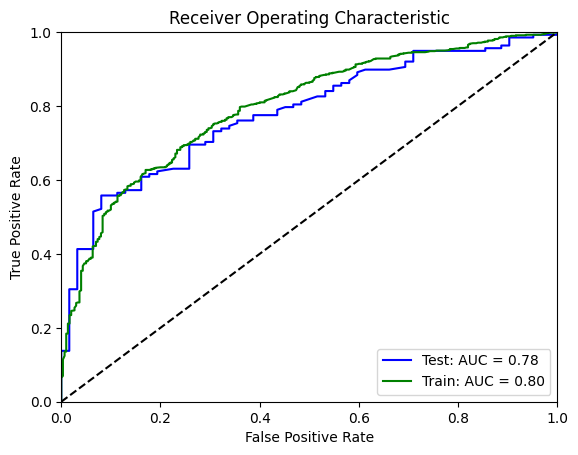

In [27]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test, proba_test)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y, proba_train)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Test: AUC = {0:.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'g', label='Train: AUC = {0:.2f}'.format(roc_auc2))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

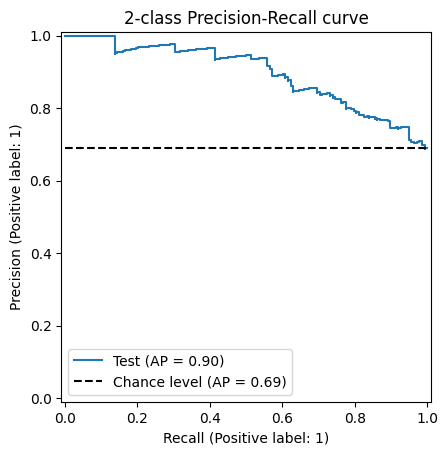

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    scorecard, X_test, y_test, name="Test", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Feature Importance

In [29]:
from skorecard.reporting import iv

model_stats = scorecard.get_stats()

X_train_bins = scorecard.bucket_transform(X)
iv_dict = iv(X_train_bins, y)

iv_values = pd.Series(iv_dict).sort_values(ascending=False)
iv_values.name = "IV"

feat_importance = model_stats[["Coef."]].join(iv_values)
feat_importance["importance"] = -1.0 * feat_importance["Coef."] * feat_importance["IV"]
feat_importance.sort_values(by="importance", ascending=False)

,Coef.,IV,importance
installment_rate,0.928710,0.026310,-0.024435
purpose,0.972758,0.167459,-0.162897
credit_history,0.768291,0.291600,-0.224034
duration,0.965580,0.312167,-0.301422
status,0.892743,0.665753,-0.594346
const,0.871679,NaN,NaN


A general [rule-of-thumb](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html), is IV > 0.02 should be included.

| Information Value | Variable Predictiveness     |
|:-----------------:|-----------------------------|
|   Less than 0.02  | Not useful for prediction   |
|    0.02 to 0.1    | Weak predictive Power       |
|     0.1 to 0.3    | Medium predictive Power     |
|     0.3 to 0.5    | Strong predictive Power     |
|       > 0.5       | Suspicious Predictive Power |

# Deployment

## Post Processing: Convert to Scores

Convert the probabilities to scores. [Credit scorecard development process](https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b)

In [30]:
from skorecard.rescale import calibrate_to_master_scale
import numpy as np

proba_train = pd.Series(proba_train, index=X.index).sort_values()  # sorting for visualization purposes

ref_score = 400
ref_odds = 3
pdo = 20

scores = calibrate_to_master_scale(proba_train, pdo=pdo, ref_score=ref_score, ref_odds=ref_odds)

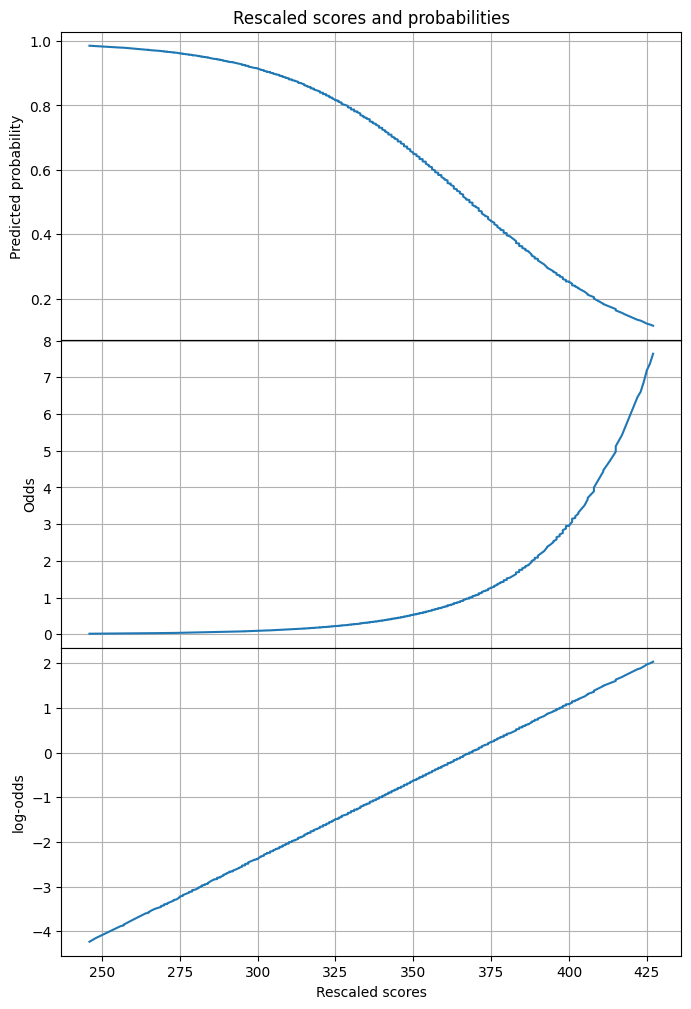

In [31]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12), gridspec_kw={"hspace": 0})
ax1.plot(scores.values, proba_train.values)

ax1.set_ylabel("Predicted probability")
ax1.set_title("Rescaled scores and probabilities")
ax1.grid()


ax2.plot(scores.values, proba_train.apply(lambda x: (1 - x) / x).values)
ax2.set_ylabel("Odds")
ax2.grid()


ax3.plot(
    scores.values,
    proba_train.apply(lambda x: np.log(1 - x) - np.log(x)).values,
)
ax3.set_ylabel("log-odds")
ax3.grid()
ax3.set_xlabel("Rescaled scores")

plt.show()

## Create scorecard

This step converts the buckets to Points.

This is essentially the same as:

![](https://www.lancaster.ac.uk/stor-i-student-sites/katie-howgate/wp-content/uploads/sites/23/2021/02/MockScorecard.png)

From Katie Howgate's ["How to build a scorecard"](https://www.lancaster.ac.uk/stor-i-student-sites/katie-howgate/2021/02/07/how-to-build-a-credit-scorecard/)

In [32]:
from skorecard.rescale import ScoreCardPoints

# ensure that pdo, ref_score and ref_odds are consistent
scp = ScoreCardPoints(skorecard_model=scorecard, pdo=20, ref_score=400, ref_odds=3)

In [33]:
#scp.get_params()

In [34]:
scp.get_scorecard_points()

,bin_index,map,woe,feature,coef,contribution,Points
0,0,"(-inf, 8.08]",-0.337237,duration,0.965580,-0.325629,78
1,1,"(8.08, 11.48]",0.514617,duration,0.965580,0.496904,54
2,2,"(11.48, 12.16]",0.119668,duration,0.965580,0.115549,65
3,3,"(12.16, 15.56]",1.201250,duration,0.965580,1.159902,35
4,4,"(15.56, 18.96]",0.026975,duration,0.965580,0.026046,68
5,5,"(18.96, 26.44]",-0.199149,duration,0.965580,-0.192295,74
6,6,"(26.44, 34.6]",-1.123091,duration,0.965580,-1.084434,100
7,7,"(34.6, 43.440000000000005]",-0.527169,duration,0.965580,-0.509024,83
8,8,"(43.440000000000005, inf]",0.611781,duration,0.965580,0.590723,52
9,-1,Missing,0.000000,duration,0.965580,0.000000,69


In [35]:
df_score = scp.transform(X_test)
df_score['score'] = df_score.sum(axis=1, skipna=True)
df_score

,duration,status,credit_history,purpose,installment_rate,score
521,83,59,71,57,73,343
737,68,59,96,47,73,343
740,65,59,71,57,65,317
660,78,79,71,47,73,348
411,74,59,71,75,73,352
...,...,...,...,...,...,...
408,68,79,71,75,65,358
332,78,59,96,47,62,342
208,52,79,53,79,73,336
613,35,90,71,57,73,326


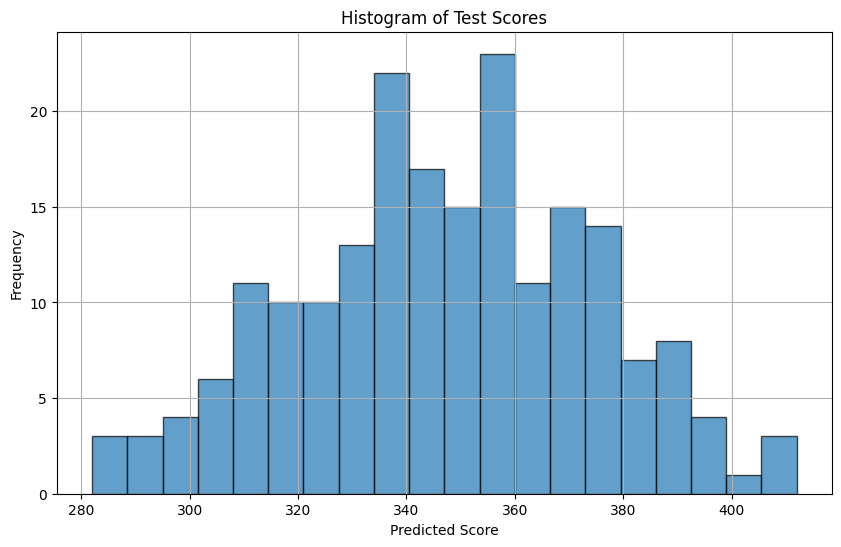

In [36]:
import matplotlib.pyplot as plt

# Create a histogram of the 'Score' column
plt.figure(figsize=(10, 6))
plt.hist(df_score['score'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Test Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Lab Questions

## Question 1 (Short): Calibration

Calibration is a model validation technique to compare the model's predicted probabilities versus it's actual.

Follow [this Calibration tutorial](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#calibration-curves).

You will need to minimize the code, ploting the Train **and** Test datasets using [`CalibrationDisplay`](https://scikit-learn.org/stable/modules/calibration.html#calibration).

You don't need to plot the Histogram.

**Question:** You are a model risk manager who is validating this model before it is approved for use.

Does the Test data match the intended predicted probabilities? Analyze the effectiveness of the model to predict its intended probability.

Are you comfortable approving this model for production?

`<!-- Answer here -->`
I would not approve this model. For the bucket with probailty around  0.2 the fraction of positive is 0.8. It means the model is failing in identifying these as Class 1. And this is significantly high to not approve a model like this.

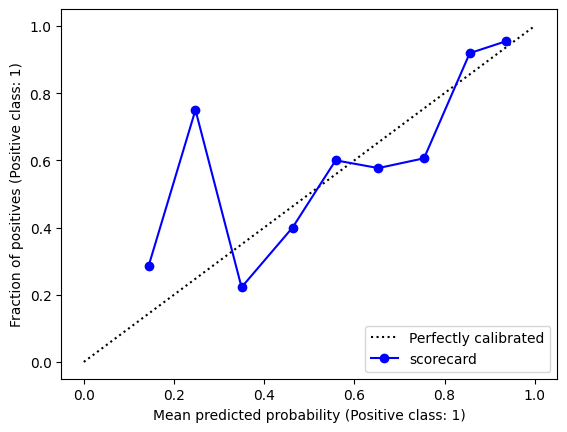

In [37]:
# fill in the blank (about 20 lines of code):
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_estimator(
        scorecard,
        X_test,
        y_test,
        n_bins=10,
        name="scorecard",
        strategy="uniform",
        color='blue',
        marker="o",
    )

## Question 2 (Short): Population Stability Index (PSI)

Over time, new input data can change. To measure this, PSI is based on comparing the training inputs and another dataset (e.g., Test, out-of-sample, etc.)

Compare the `X_train` vs `X_test` using the `EqualWidthBucketer`.

You should then get 5 PSI calculations, one for each feature.

Given this table:

| PSI | Interpretation     |
|:-----------------:|-----------------------------|
| PSI < 0.1 | No change. You can continue using existing model. |
| 0.1 <= PSI >= < 0.2 | Slight change is required. |
| PSI >=0.2 | Significant change is required. Ideally, you should not use this model anymore, retraining is required. |

**Question**: Assume you're still validating this model.

Is there evidence the inputs' distributions have changed significantly?

`<!-- Answer here -->`

No. accourding to PSI. There is no shift in the distribution between test and train data.

In [38]:
# fill in the blank (Less than 10 lines of code):
from skorecard.reporting import psi

#X_train_bins = scorecard.bucket_transform(X)
X_test_bins = scorecard.bucket_transform(X_test)
psi_dict = psi(X_train_bins, X_test_bins)
psi_dict

{'status': 0.008129314255555993,
 'credit_history': 0.005997580110465218,
 'purpose': 0.016816872096363088,
 'installment_rate': 0.009709808548427429,
 'duration': 0.049381818430955446}

## Question 3 (Long): Business Decision

Let's assume from a business value matrix of:
      

|   | B (actual) | G (actual)   |
|---|-------|-----|
| B (model) | 0   | -1  |
| G (model) | -5 | 0 |

Said differently, it takes 5 goods to offset 1 bad.

Use this [tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html).

Answer these three questions (Just number or Yes/No):
1. What is the business value of a 50% threshold? `<!-- Answer here -->`  -112
2. What threshold maximizes business value? `<!-- Answer here -->` 0.10
3. At that threshold, is your business profitable? `<!-- Answer here -->`  at the treshold the bussiness value is -62 so its still not profitable.

Add in code below after `# fill in blank:`

In [50]:
# define fpr_score, assign pos_label/neg_label, and create socring
# fill in blank:

from sklearn.metrics import confusion_matrix
neg_label = 0
pos_label = 1

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

fpr_score_value = fpr_score(y_test, scorecard.predict(X_test), neg_label, pos_label)
print(fpr_score_value)


0.5967741935483871


In [40]:
# define credit_gain_score (correctly updating gain_matrix) and run it
# fill in blank:
from sklearn.metrics import make_scorer

def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


credit_gain_score_value = credit_gain_score(y_test, scorecard.predict(X_test), neg_label, pos_label)
print(credit_gain_score_value)

-112


In [41]:
from sklearn.metrics import make_scorer, precision_score, recall_score

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}
scoring["cost_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label
)

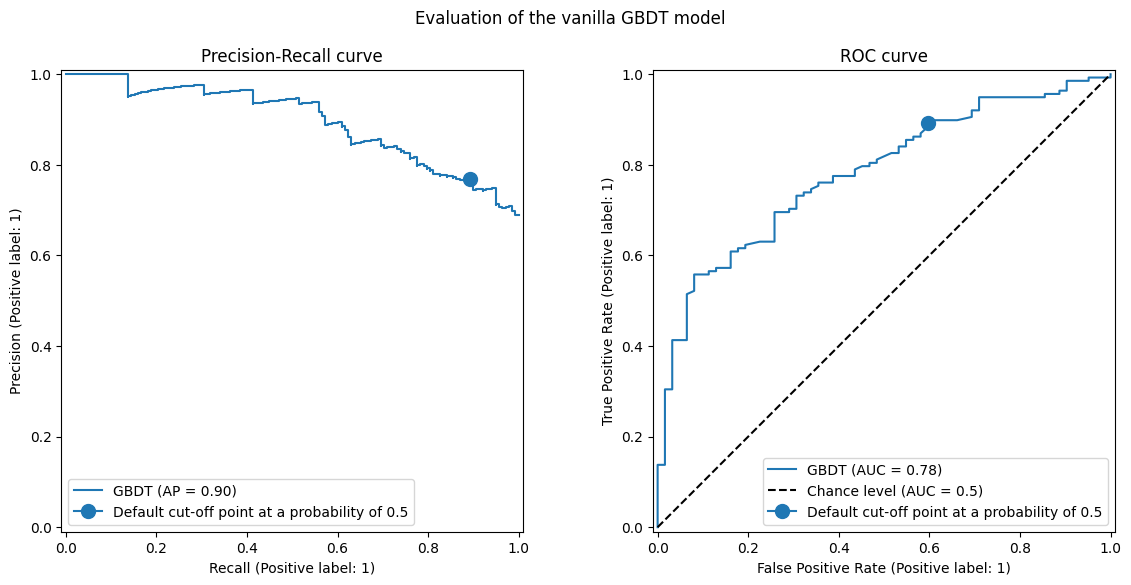

In [42]:
# plot Precision-Recall at 50% using PrecisionRecallDisplay and RocCurveDisplay
# fill in blank (~30 lines of code):


from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
model= scorecard
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, pos_label=pos_label, ax=axs[0], name="GBDT"
)
axs[0].plot(
    scoring["recall"](model, X_test, y_test),
    scoring["precision"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=pos_label,
    ax=axs[1],
    name="GBDT",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](model, X_test, y_test),
    scoring["tpr"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the vanilla GBDT model")

In [43]:
# Run scoring['cost_gain'] to get the business value at a 50% threshold
# fill in blank (1 print statement):
print(f"Business defined metric: {scoring['cost_gain'](model, X_test, y_test)}")


Business defined metric: -112


In [44]:
# Use TunedThresholdClassifierCV to tune threshold; be sure to use train, not test
# fill in blank (< 10 lines):

from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

tuned_model.best_threshold_=0.10


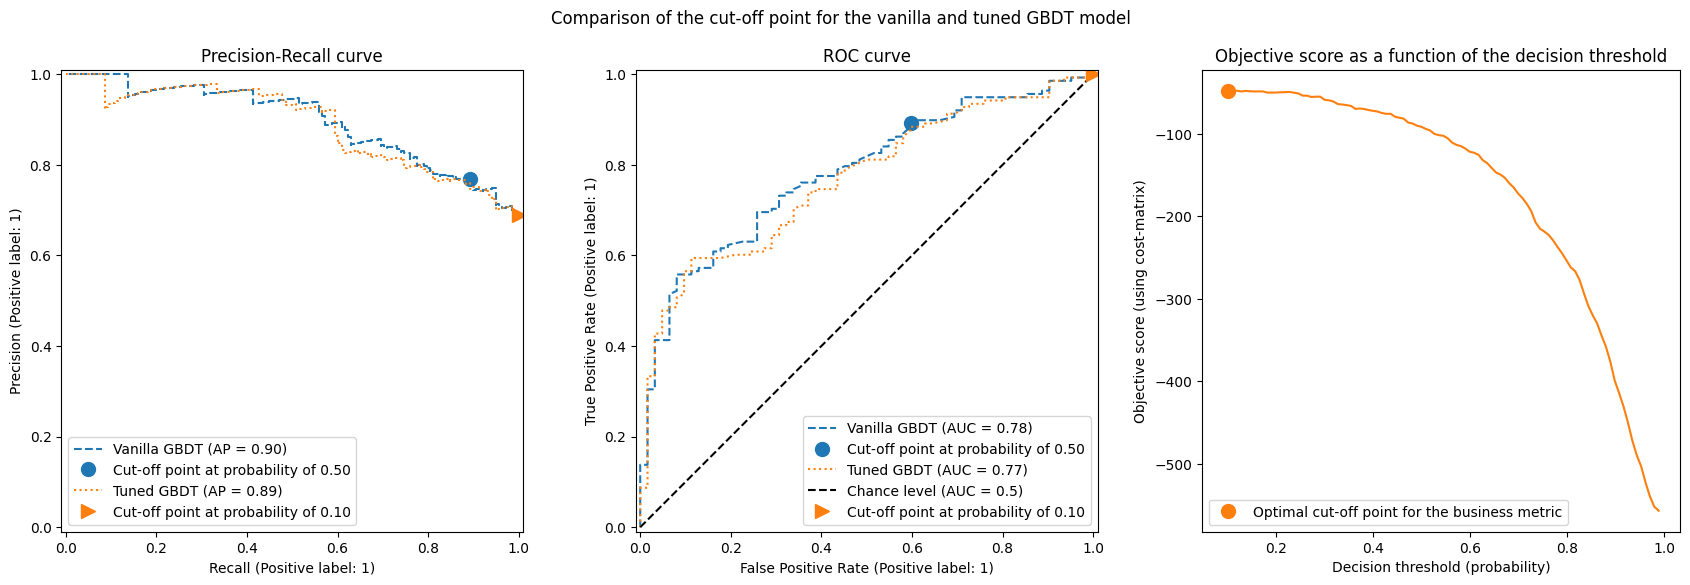

In [47]:
# define and run plot_roc_pr_curves; you will need to change names
def plot_roc_pr_curves(vanilla_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla GBDT", "Tuned GBDT")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)


title = "Comparison of the cut-off point for the vanilla and tuned GBDT model"
plot_roc_pr_curves(model, tuned_model, title=title)


In [49]:
print(f"Business defined metric: {scoring['cost_gain'](tuned_model, X_test, y_test)}")


Business defined metric: -62
